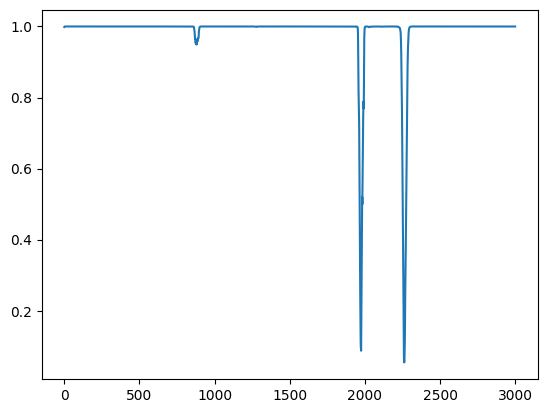

In [ ]:
from typing import Literal
from matplotlib import pyplot as plt
import numpy as np
import torch
from sklearn import metrics

from seisbench.models import PhaseNet

sampling_rate = 100.0
pn = PhaseNet.from_pretrained("original")


waveform_data = torch.load("example_waveform.pt", map_location=torch.device("cpu"))
labels = torch.load("example_labels.pt", map_location=torch.device("cpu"))
predictions = torch.load("example_predictions.pt", map_location=torch.device("cpu"))

predictions = pn.forward(waveform_data)

if pn.labels == "NPS":
    predictions = torch.roll(predictions, -1, dims=1)

# plt.plot(predictions[2, 2, :].detach().numpy())
plt.plot(predictions[2, 2].detach().numpy())

In [ ]:
score_detection = torch.zeros(predictions.shape[0])
score_p_or_s = torch.zeros(predictions.shape[0])
for i in range(predictions.shape[0]):
    score_detection[i] = torch.max(1 - predictions[-1])  # 1 - noise
    score_p_or_s[i] = torch.max(predictions[0]) / torch.max(predictions[1])


scores = {"detection": score_detection, "phase": score_p_or_s}

In [3]:
score_detection

tensor([0.7287, 0.7287, 0.7287,  ..., 0.7287, 0.7287, 0.7287])

In [4]:
torch.mean(torch.abs(predictions - labels)).item()

0.47584534296671177

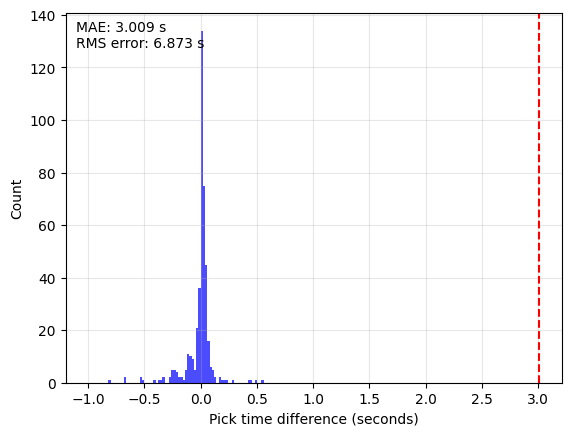

In [77]:
ComponentOrder = Literal["NPS", "PSN"]

ORDER_MAP: dict[ComponentOrder, tuple[int, int]] = {
    "NPS": (1, 2),
    "PSN": (0, 1),
}


def get_pick_differences(
    predictions: torch.Tensor,
    labels: torch.Tensor,
    order: ComponentOrder = "PSN",
    min_pick_height: float = 0.3,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    prediction_max, prediction_pick_sample = predictions.max(dim=2)
    label_max, label_pick_sample = labels.max(dim=2)
    p_idx, s_idx = ORDER_MAP[order]

    # Some samples may not have a pick for P or S wave
    p_mask = label_max[:, p_idx].to(bool)
    s_mask = label_max[:, s_idx].to(bool)

    p_mask &= prediction_max[:, p_idx] >= min_pick_height
    s_mask &= prediction_max[:, s_idx] >= min_pick_height

    p_predicted_picks = prediction_pick_sample[:, p_idx][p_mask]
    p_labeled_picks = label_pick_sample[:, p_idx][p_mask]

    s_predicted_picks = prediction_pick_sample[:, s_idx][s_mask]
    s_labeled_picks = label_pick_sample[:, s_idx][s_mask]

    return p_predicted_picks, p_labeled_picks, s_predicted_picks, s_labeled_picks


p_pred, p_label, s_pred, s_label = get_pick_differences(
    predictions, labels, order="PSN"
)


def plot_histogram(
    predicted: np.ndarray, label: np.ndarray, sampling_rate: float
) -> None:
    fig = plt.figure()
    ax = fig.gca()
    offset = (predicted - label) / sampling_rate  # in seconds
    ax.hist(
        offset,
        bins=100,
        range=(-1, 1),
        alpha=0.7,
        color="blue",
    )
    ax.set_xlabel("Pick time difference (seconds)")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)

    mean_error = torch.mean(torch.abs(torch.from_numpy(offset)))
    mean_error = metrics.mean_absolute_error(label, predicted) / sampling_rate

    rms_error = np.sqrt(np.mean(offset**2))

    ax.axvline(mean_error, color="red", linestyle="dashed", label="Mean offset")

    # TODO: Add fraction which is outside the plotted range
    ax.text(
        0.02,
        0.98,
        f"MAE: {mean_error:.3f} s\nRMS error: {rms_error:.3f} s",
        transform=ax.transAxes,
        verticalalignment="top",
    )

    plt.show()


plot_histogram(s_pred.numpy(), s_label.numpy(), sampling_rate=100.0)

In [ ]:
offset = (p_pred.numpy() - p_label.numpy()) / sampling_rate

In [22]:
torch.mean(torch.abs(torch.from_numpy(offset)))

tensor(4.7117, dtype=torch.float64)

In [23]:
y_true = (p_label).numpy()
y_pred = (p_pred).numpy()
sampling_rate = 100  # Hz → each sample = 0.01 s
time_per_sample = 1 / sampling_rate

rmse_samples = metrics.mean_absolute_error(y_true, y_pred)
rmse_seconds = rmse_samples * time_per_sample

Difference in samples: 0
tensor(True)


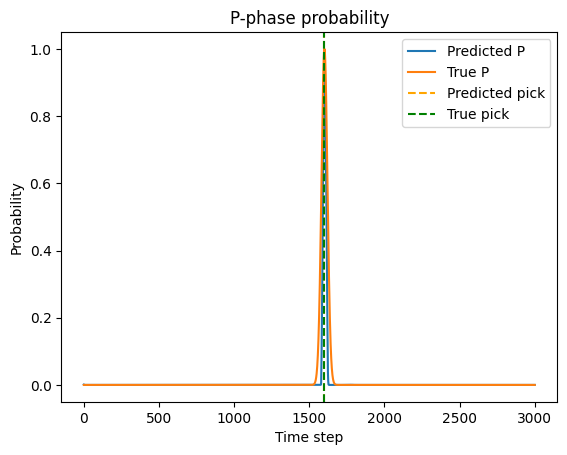

In [72]:
sample = 149
channel = 0  # P-wave channel
prediction_max, prediction_pick_sample = predictions.max(dim=2)
label_max, label_pick_sample = labels.max(dim=2)


pred_sample = prediction_pick_sample[sample, channel]
labled_sample = label_pick_sample[sample, channel]
print(f"Difference in samples: {pred_sample - labled_sample}")
print(labled_sample.to(bool))

plt.plot(predictions[sample, channel, :].detach(), label="Predicted P")
plt.plot(labels[sample, channel, :].detach(), label="True P")
plt.axvline(x=pred_sample, color="orange", linestyle="--", label="Predicted pick")
plt.axvline(x=labled_sample, color="green", linestyle="--", label="True pick")
plt.xlabel("Time step")
plt.ylabel("Probability")
plt.title("P-phase probability")
plt.legend()
plt.show()
